## Simple Linear Regression

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
tips = sns.load_dataset("tips")
tips.head(5)

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


I'm interested in studying the **relationship between two variables**. Specifically, in the relationship between the `total_bill` column and `tip` column. The goal will be to predict tip ($y$) from total_bill ($x$), i.e., I want to find values of $a$ and $b$ so that given $x$, I can predict $y$ as $$\boxed{\hat{y} = a + bx}$$
I will first explore different ways (manually, scipy.optimize, and scikit-learn) to obtain the optimal values of $a, b$, called $\hat{a}, \hat{b}$, where $\hat{y} = \hat{a} + \hat{b}x$.

<Figure size 300x300 with 0 Axes>

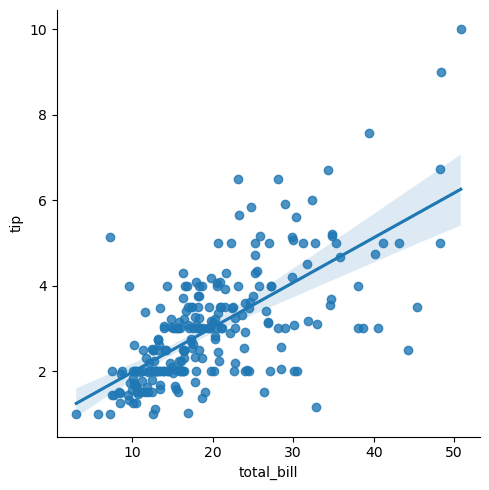

In [3]:
# Take a look at relationship and least-squares line of best fit
plt.figure(figsize=(3,3))
sns.lmplot(data = tips, x = "total_bill", y = "tip");

### Manual Formulation

If I use squared loss I can use the following expressions to manually calculate the line of best fit.

$$\hat{a} = \bar{y} - \hat{b}\bar{x}$$

$$\hat{b} = r\frac{\sigma(y)}{\sigma(x)}$$

where $\bar{x}$, $\bar{y}$, $\sigma(x)$, $\sigma(y)$ correspond to the means and standard deviations of $x$ and $y$, respectively, and $r$ is the correlation coefficient.

In [4]:
x_bar = np.mean(tips['total_bill'])
y_bar = np.mean(tips['tip'])
std_x = np.std(tips['total_bill'])
std_y = np.std(tips['tip'])
r = np.corrcoef(tips['total_bill'], tips['tip'],)[0, 1]

b_hat = r * (std_y / std_x)
a_hat = y_bar - (b_hat * x_bar)

print("The value of a is", a_hat, "and the value of b is", b_hat)

The value of a is 0.9202696135546726 and the value of b is 0.1050245173843534


The predicted tip for a bill of $20 is 3.0207599612417404


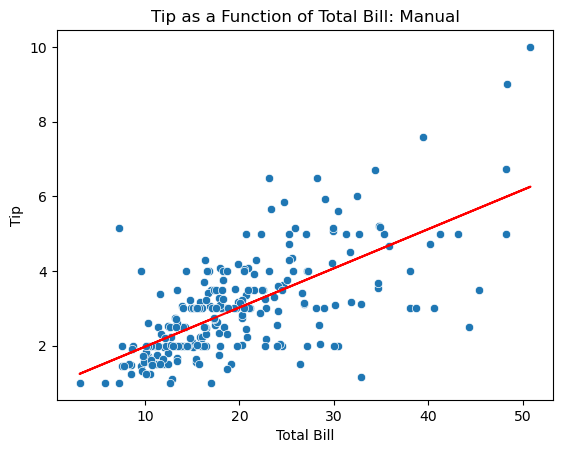

In [5]:
# Now I can use `a_hat` and `b_hat` to predict the tip for a total bill amount of $20
print("The predicted tip for a bill of $20 is", a_hat + (b_hat * 20))

# Can also make a prediction for each observed value of 'total bill' and plot the line of best fit
regression = a_hat + (b_hat * tips["total_bill"])
sns.scatterplot(x='total_bill', y='tip', data=tips)
plt.plot(tips["total_bill"], regression, color = 'r')
plt.title("Tip as a Function of Total Bill: Manual")
plt.xlabel('Total Bill')
plt.ylabel('Tip')
plt.show();

In [6]:
# r is a measure of how close your prediction is to the actual values
# an r value of 1 or -1 would be perfect correlation(negative or positive) and 0 would be no correlation at all
# a r value of 0.6757 tells us that the relationship isn't perfect but its pretty good.
r

0.6757341092113641

### Scipy Minimize

`scipy.minimize` is a powerful method that can determine the optimal value of a variety of different functions. In practice, it is used to minimize functions that have no (or difficult to obtain) analytical solutions (it is a **numerical method**). For the tips data it in a bit overkill.

The `minimize` function can minimize functions of multiple variables. However, the function has to accept its parameters as a single list.

For example, consider the multivariate $f(u, v) = u^2 - 2 u v - 3 v + 2 v^2$. It turns out this function's minimum is at $(1.5, 1.5)$. To minimize this function, I create `f`.

In [7]:
def f(theta):
    u = theta[0]
    v = theta[1]
    return u**2 - 2 * u * v - 3 * v + 2 * v**2

# x0 is the "initial guess" for the optimal theta. minimize works iteratively.
minimize(f, x0=[0,0]) 

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -2.2499999999999982
        x: [ 1.500e+00  1.500e+00]
      nit: 3
      jac: [-5.960e-08  0.000e+00]
 hess_inv: [[ 1.000e+00  5.000e-01]
            [ 5.000e-01  5.000e-01]]
     nfev: 12
     njev: 4

To use this on the tips data I define a function that computes the empirical risk for a given choice of a and b, where a and b are passed in a list theta. That is, it computes 
$$R(a, b) = \frac{1}{n} \sum_{i = 1}^n(y_i - (a + b x_i))^2$$

In [8]:
 def l2_tip_risk_list(theta):
    # Returns average l2 loss between regression line for intercept a and slope b
    y = tips['tip']
    x = tips['total_bill']
    sum = np.sum((y-(theta[0]+(theta[1]*x)))**2)
    return sum / len(x)

minimized = minimize(l2_tip_risk_list, x0=[2,3])

print('a_hat_scipy: ', minimized['x'][0])
print('a_hat_manual: ', a_hat)
print('b_hat_scipy: ', minimized['x'][1])
print('b_hat_manual: ', b_hat)

a_hat_scipy:  0.9202705028165612
a_hat_manual:  0.9202696135546726
b_hat_scipy:  0.10502446828548423
b_hat_manual:  0.1050245173843534


Text(0, 0.5, 'Tip')

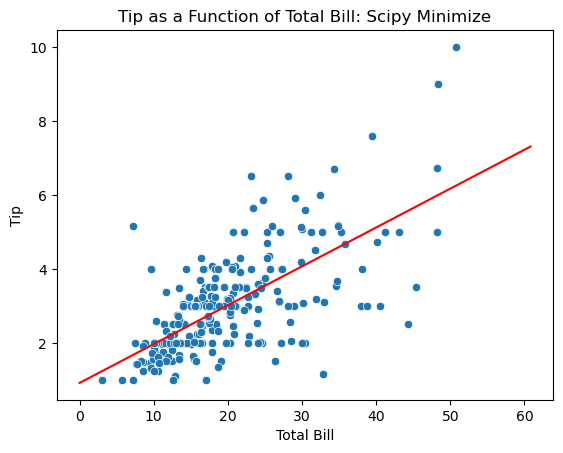

In [9]:
x = np.linspace(0, max(tips['total_bill'])+10)
plt.plot(x, (minimized['x'][1] * x) + minimized['x'][0], color='red')
sns.scatterplot(data=tips, x='total_bill', y='tip')
plt.title("Tip as a Function of Total Bill: Scipy Minimize")
plt.xlabel('Total Bill')
plt.ylabel('Tip')

The reason these don't match past the first 5 decimal places is due to the fact that `scipy.minimize` is a numerical method, meaning it approximates the optimal value using some sort of non-algebraic procedure. These values are essentially the same.

### Scikit Learn

Another way to fit a linear regression model is to use scikit learn, an industry standard package for machine learning applications. 

To do so, I first create a `LinearRegression` object.

In [10]:
# `model` is like a "blank slate" for a linear model
model = LinearRegression()

# tell `model` to "fit" itself to the data
# essentially just creating a risk function and finding the parameters that minimize that risk (like in the last part)
# X needs to be a matrix (or DataFrame), as opposed to a single array (or Series)
model.fit(X = tips[['total_bill']], y= tips['tip'])

print("Coefficent:", model.coef_)
print("Intercept:", model.intercept_)
print("The model predicts a tip of", round(model.predict([[20]])[0], 2), "for a $20 bill") # 20 needs to be a 2D array since the X above was a 2D array.

Coefficent: [0.10502452]
Intercept: 0.9202696135546731
The model predicts a tip of 3.02 for a $20 bill


/Users/clairecoughran/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Text(0, 0.5, 'Tip')

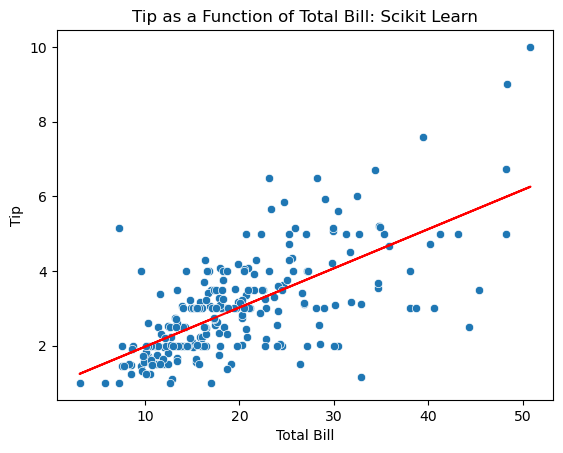

In [11]:
plt.plot(tips['total_bill'], model.predict(tips[['total_bill']]), color='red')
sns.scatterplot(data=tips, x='total_bill', y='tip')
plt.title("Tip as a Function of Total Bill: Scikit Learn")
plt.xlabel('Total Bill')
plt.ylabel('Tip')